In [1]:
import sys

import sklearn
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge, LogisticRegression, Lasso, LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

%matplotlib inline

pd.options.mode.chained_assignment = None

In [2]:
# Import data

train = pd.read_csv('data/house-prices/train.csv', index_col=['Id'])
test = pd.read_csv('data/house-prices/test.csv', index_col=['Id'])

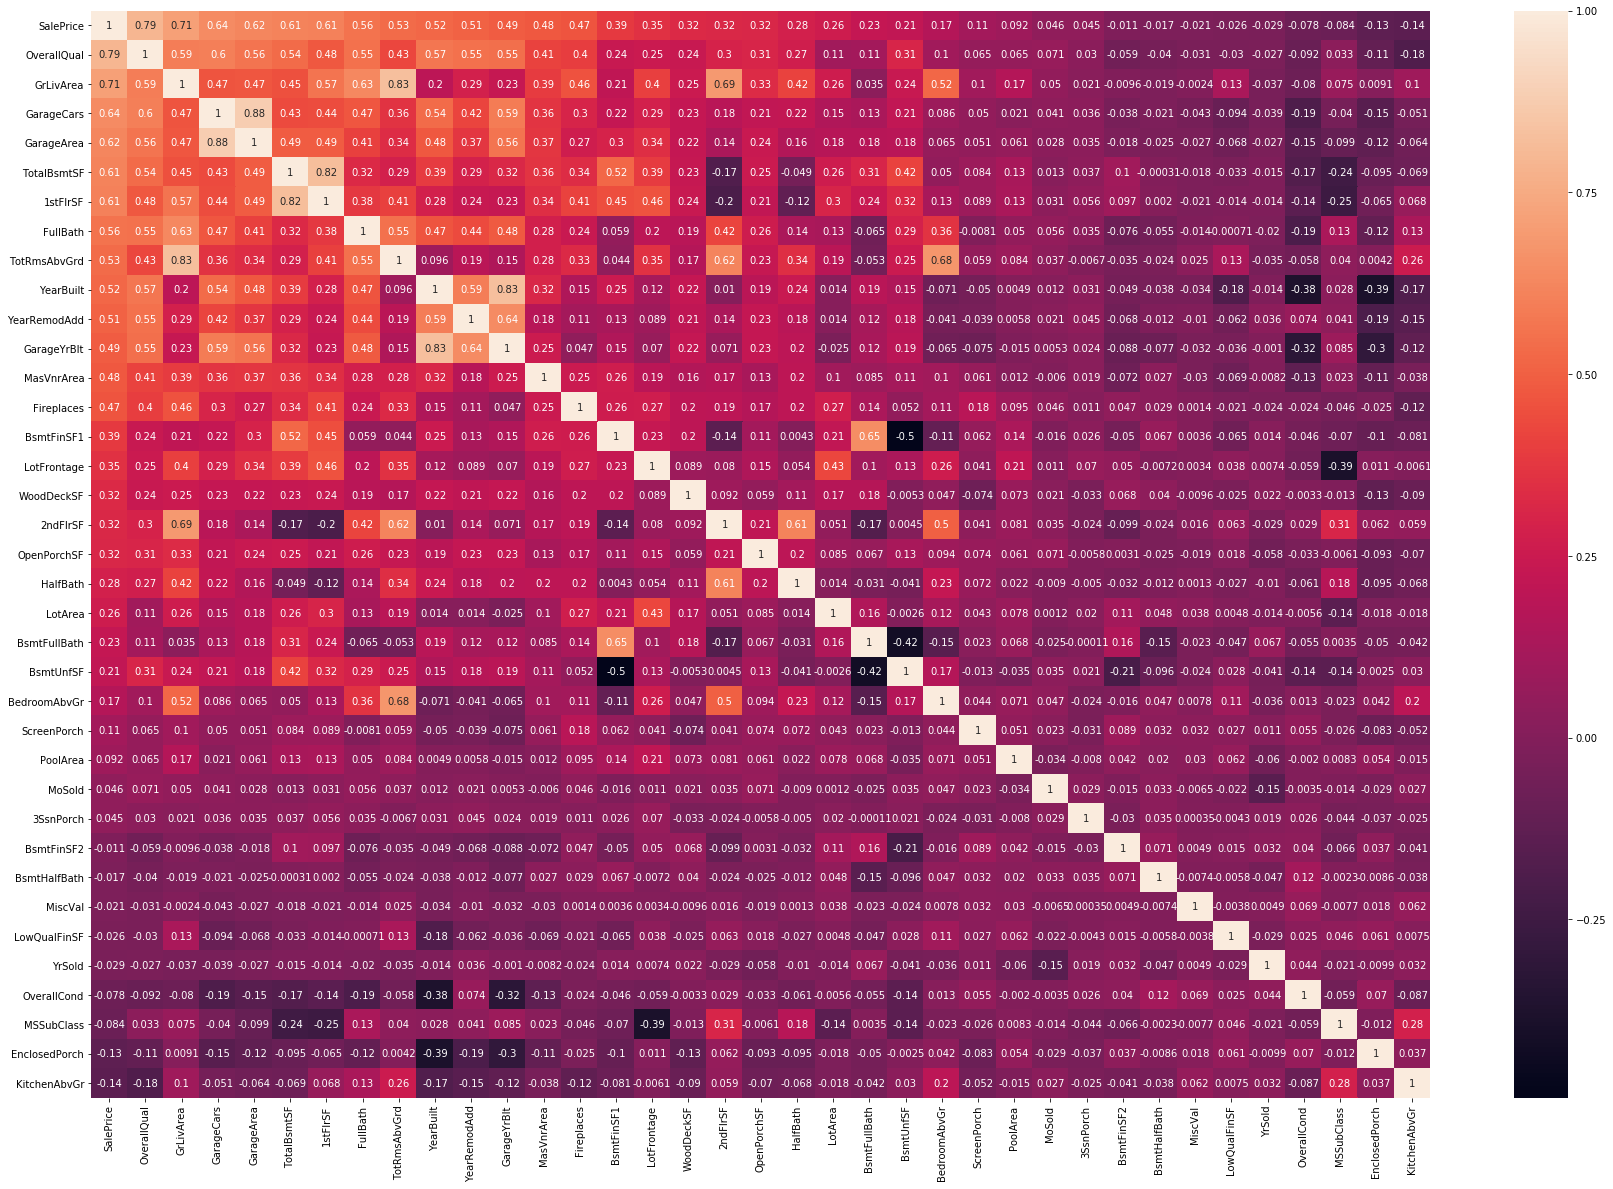

In [3]:
# First of all, let's take a look at the correlation matrix for our dataset

corr=train.corr()
top_corr=train[corr.nlargest(40,'SalePrice')['SalePrice'].index].corr()
figure, ax1 = plt.subplots(nrows=1, ncols=1)
figure.set_size_inches(30,20)
sns.heatmap(top_corr, annot=True, ax=ax1)

In [4]:
# Some features strongly correlate with another one, so it should be save to remove them

train =  train.drop(['GarageArea', '1stFlrSF', 'TotRmsAbvGrd'], axis=1)

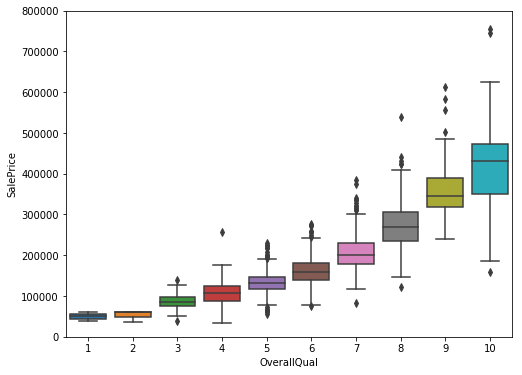

In [5]:
# The overall quality seems rather linear with the SalePrice

data = pd.concat([train['SalePrice'], train['OverallQual']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='OverallQual', y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

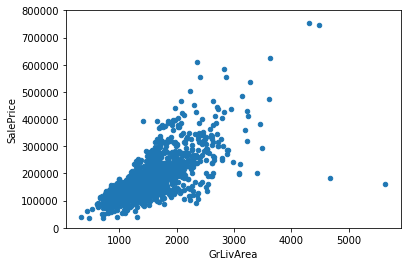

In [6]:
# GrLivArea is linear with the sale price as well

data = pd.concat([train['SalePrice'], train['GrLivArea']], axis=1)
data.plot.scatter(x='GrLivArea', y='SalePrice', ylim=(0,800000));

In [7]:
# There seem to be two heavy outliers. Removing them, however, significantly worsened my model

# train=train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

In [8]:
# Let's take a look at the missing feature value percentages

total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageCond,81,0.055479
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479


In [9]:
# Removing the features with the highest percentage and their dependent features slightly improved the model score

train=train.drop(columns=['PoolArea','PoolQC', 'MiscVal','MiscFeature', 'Alley', 'Fence', 'Fireplaces', 'FireplaceQu'])

In [10]:
# For some categorical features, NA has a special meaning
# However, we can replace the missing values in some other categorical features with the mode

for col in ('MasVnrType', 'Electrical'):
    train[col] = train[col].fillna(train[col].mode()[0])

In [11]:
# Presenting some numeric features as categorical improved the model

for col in ('MSSubClass', 'MoSold', 'YrSold'):
    train[col] = train[col].astype(str)

In [12]:
# I tried removing some of the features which had mostly the same value, but this made the score slightly worse

# train=train.drop(columns=['Street','Utilities','Condition2','RoofMatl','Heating'])

In [13]:
# Split train data into train/test sets

train_no_sale_price = train.drop(labels=['SalePrice'], axis=1)
train_sale_price = train['SalePrice']

x_train, x_test, y_train, y_test = train_test_split(train_no_sale_price, 
                                                    train_sale_price, 
                                                    test_size=0.3, 
                                                    random_state=4330)

In [14]:
# I tried different strategies for replacing numeric values, using the mean of the train set gave me the best results

def replace_na_with_mean():
    return replace_with_imputer("mean")

def replace_na_with_median():
    return replace_with_imputer("median")

def replace_na_with_zero():
    (x_train_numeric, x_test_numeric) = get_numeric_sets()
    x_train_numeric = x_train_numeric.fillna(0)
    x_test_numeric = x_test_numeric.fillna(0)
    return (x_train_numeric, x_test_numeric)

def replace_with_imputer(strategy):
    (x_train_numeric, x_test_numeric) = get_numeric_sets()
    imputer = SimpleImputer(missing_values=np.nan, strategy=strategy)
    imputer = imputer.fit(x_train_numeric)

    x_train_numeric = imputer.transform(x_train_numeric)
    x_test_numeric = imputer.transform(x_test_numeric)
    return (x_train_numeric, x_test_numeric)

def get_numeric_sets():
    numeric_column_names = x_train.describe().columns
    return (x_train[numeric_column_names], x_test[numeric_column_names])



In [15]:
# Encode the remaining categorical values

def hot_encode():
    categorical_columns = train.dtypes[train.dtypes == 'object'].index
    
    train_with_no_na = train[categorical_columns].fillna("None")
    x_train_no_na = x_train[categorical_columns].fillna("None")
    x_test_no_na = x_test[categorical_columns].fillna("None")
    
    one_hot_encoder = OneHotEncoder().fit(train_with_no_na[categorical_columns])

    one_hot_x_train = one_hot_encoder.transform(x_train_no_na[categorical_columns])
    one_hot_x_test = one_hot_encoder.transform(x_test_no_na[categorical_columns])
    return(one_hot_x_train, one_hot_x_test)

In [16]:
# Merge numeric and categorical values

def merge_sets(numeric_strategy):
    (x_train_numeric, x_test_numeric) = numeric_strategy()
    (one_hot_x_train, one_hot_x_test) = hot_encode()
    merged_x_train = pd.np.concatenate([one_hot_x_train.todense(), x_train_numeric], axis=1)
    merged_x_test = pd.np.concatenate([one_hot_x_test.todense(), x_test_numeric], axis=1)
    return(merged_x_train, merged_x_test)

(x_train, x_test) = merge_sets(replace_na_with_mean)

In [17]:
# Using Lasso with small alpha values yielded the best results for me.
# The scores of the linear and logistic regressions on the merged sets were overfitting horribly

def regularize_ridge():
    allScores = []
    for alpha in [0.001, 0.1, 0.5, *range(1, 100)]:
        all_data_lr = Ridge(alpha = alpha).fit(x_train, pd.np.log10(y_train))
        allScores.append({"trainingScore": all_data_lr.score(x_train, pd.np.log10(y_train)),
                          "testScore": all_data_lr.score(x_test, pd.np.log10(y_test)),
                          "alpha": alpha})
    bestScore=max(allScores, key=lambda score:score["testScore"])
    print('Ridge with alpha:', bestScore['alpha'])
    print('Training set score:', bestScore['trainingScore'])
    print('Test set score', bestScore['testScore'])
    print()

def regularize_lasso():
    allScores = []
    for alpha in np.arange(0.00001, 0.005, 0.00005):
        all_data_lr = Lasso(alpha = alpha).fit(x_train, pd.np.log10(y_train))
        allScores.append({"trainingScore": all_data_lr.score(x_train, pd.np.log10(y_train)),
                          "testScore": all_data_lr.score(x_test, pd.np.log10(y_test)),
                          "alpha": alpha})
    bestScore=max(allScores, key=lambda score:score["testScore"])
    print('Lasso with alpha:', bestScore['alpha'])
    print('Training set score:', bestScore['trainingScore'])
    print('Test set score', bestScore['testScore'])
    print()
        
def linear_regression():
    regression = LinearRegression().fit(x_train, y_train)
    print("Linear regression")
    print("Training set score: {:.3f}".format(regression.score(x_train, y_train)))
    print("Test set score:     {:.3f}".format(regression.score(x_test, y_test)))
    
def logistic_regression():
    regression = LogisticRegression().fit(x_train, y_train)
    print("Logistic regression")
    print("Training set score: {:.3f}".format(regression.score(x_train, y_train)))
    print("Test set score:     {:.3f}".format(regression.score(x_test, y_test)))
    
    
regularize_lasso()
regularize_ridge()
linear_regression()
logistic_regression()

Lasso with alpha: 0.00021
Training set score: 0.9267403127253683
Test set score 0.9368123691945216

Ridge with alpha: 26
Training set score: 0.904571841424733
Test set score 0.9263050938606714

Linear regression
Training set score: 0.930
Test set score:     -3284716265922.881


c:\users\asd__\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\asd__\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Logistic regression
Training set score: 0.977
Test set score:     0.002


c:\users\asd__\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [20]:
# With r2_score Ridge started behaving better with smaller alpha values and yielded much better results

def regularize_ridge_r2():
    allScores = []
    for alpha in  np.arange(0.00001, 0.005, 0.00005):
        all_data_lr = Ridge(alpha = alpha).fit(x_train, pd.np.log10(y_train))
        allScores.append({"trainingScore": r2_score(10**all_data_lr.predict(x_train), y_train),
                          "testScore": r2_score(10**all_data_lr.predict(x_test), y_test),
                          "alpha": alpha})
    bestScore=max(allScores, key=lambda score:score["testScore"])
    print('Ridge with alpha:', bestScore['alpha'])
    print('Training set score:', bestScore['trainingScore'])
    print('Test set score', bestScore['testScore'])
    print()

def regularize_lasso_r2():
    allScores = []
    for alpha in  np.arange(0.00001, 0.005, 0.00005):
        all_data_lr = Lasso(alpha = alpha).fit(x_train, pd.np.log10(y_train))
        allScores.append({"trainingScore": r2_score(10**all_data_lr.predict(x_train), y_train),
                          "testScore": r2_score(10**all_data_lr.predict(x_test), y_test),
                          "alpha": alpha})
    bestScore=max(allScores, key=lambda score:score["testScore"])
    print('Lasso with alpha:', bestScore['alpha'])
    print('Training set score:', bestScore['trainingScore'])
    print('Test set score', bestScore['testScore'])
    print()
        
regularize_lasso_r2()
regularize_ridge_r2()

Lasso with alpha: 0.00011
Training set score: 0.9283075318198394
Test set score 0.9442122055893147



c:\users\asd__\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number7.313656e-17
  overwrite_a=True).T


Ridge with alpha: 0.00496
Training set score: 0.9409560838766622
Test set score 0.9273233330419175



In [21]:
# Using the standard scaler gave me a slight boost to my score

sc_x = StandardScaler()
x_train = sc_x.fit_transform(x_train)
x_test= sc_x.transform(x_test)

In [22]:
regularize_lasso_r2()
regularize_ridge_r2()

c:\users\asd__\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Lasso with alpha: 0.0009100000000000001
Training set score: 0.9312579897840833
Test set score 0.9467709276167814

Ridge with alpha: 0.00496
Training set score: 0.9410239726397492
Test set score 0.9320329262891267



Best final result:

Lasso with alpha: 0.0009100000000000001

Training score: 0.9312579897840833

Test score: 0.9467709276167814